# NLE Assignment 1: Books vs DVDs

In this assignment, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=215758 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/NLE Notebooks/resources/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#do not change the code in this cell
#preliminary imports

#for setting up training and testing data
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
import random

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from itertools import zip_longest


Sussex NLTK root directory is /content/drive/My Drive/NLE Notebooks/resources
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [5]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'I': True, 'loved': True, 'the': True, 'movie': True, 'it': True, 'has': True, 'a': True, 'lot': True, 'of': True, 'hidden': True, 'symbols': True, ',': True, 'like': True, 'Almodovar': True, 'is': True, 'accustomed': True, 'to': True, 'doing': True, '.': True, 'However': True, 'music': True, 'was': True, 'best': True}, 'dvd')


1) Use your training data to find
a) the top 20 words which occur more frequently in book reviews than in dvd reviews
b) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [20%]

In [6]:
# Download wordnet module
nltk.download('wordnet')

# Import libraries
import random
from functools import reduce 
from nltk import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def freq_words(data_set, cat): 
  """
  Get freq of words which has been normalised, lemmitized and removed stop words

  :param data_set: The data_set the words are in
  :param cat: The category of the data which you want to get the frequency of the words from
  :return: FreqDist object which you can iterate over with the frequencies contained
  """
  stop = stopwords.words('english')
  return FreqDist([WordNetLemmatizer().lemmatize(word.lower()) for row in data_set for word in row[0] if row[1] is cat and word.isalpha() and word.lower() not in stop])
 
def sort_diff_dict(freq_one, freq_two):
  diff_dict = dict() # Store the difference of freq_one vs freq_two

  # Gets the words which occur more in freq_one compared to freq_two
  for key in freq_one.keys():
    if key in freq_two.keys():
      if freq_one[key] > freq_two[key]:
        diff_dict[key] = freq_one[key]

  return sorted(diff_dict.items(), key=lambda x: x[1], reverse=True)


def top_k_freq(freq_one, freq_two, k):
  """
  Finds the most freqent words which occur more in one than two, and returns the first k amount of items from the sorted array

  :param freq_one: Frequency which you want to get the words which occur more in
  :param freq_two: Frequency which you want to compare to
  :return: List of tuples formatted like (word, occurance_count)
  """
  sort_dict_array = sort_diff_dict(freq_one, freq_two)
  # Sorts the dict and stores it as an array of tuples in ascending order
  return sort_dict_array[:k]

# Returns a dataframe of the frequency formatted correctly
def plot_q_one(freq):
  """
  Creates a panda dataframe for the returned data from top_k_freq() to be plotted
  
  :param freq: List of tuple frequencies to create the dataframe from
  :return: Panda dataframe to plot
  """
  index_words = [i[0] for i in freq] # To get the words for the barchat labels
  occurances_numbers = [i[1] for i in freq] # Get the occurance count of words
  
  # Returns formatted dataframe
  return pd.DataFrame(occurances_numbers, columns = ["Occurances"], index = index_words) 

def tuplist_to_dict(tup): 
    di = dict(tup) 
    return di 

In [8]:
# Get the normalized, lemmatized, stop-word removed frequencies of book and dvd
book_freq = freq_words(training_data, 'book')
dvd_freq = freq_words(training_data, 'dvd')

top_twenty_book_freq = top_k_freq(book_freq, dvd_freq, 20) # top twenty words which occur more frequently in book reviews than in dvd reviews
top_twenty_dvd_freq = top_k_freq(dvd_freq, book_freq, 20) # top twenty words which occur more frequently in dvd reviews than book reviews

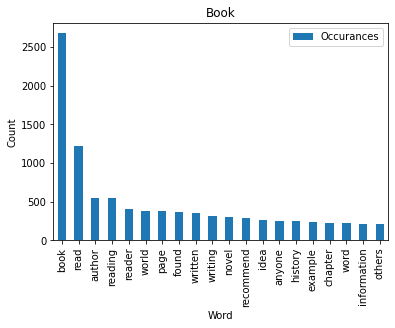

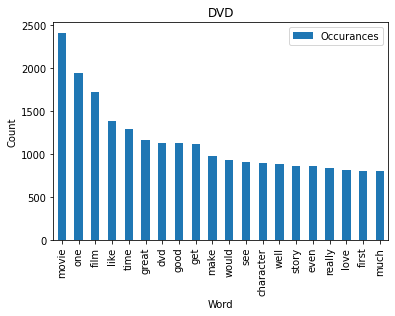

In [9]:
# Plot top twenty words from books and dvd
display(plot_q_one(top_twenty_book_freq).plot.bar(title='Book', xlabel="Word", ylabel="Count"))
display(plot_q_one(top_twenty_dvd_freq).plot.bar(title='DVD', xlabel="Word", ylabel="Count")) 

I have removed stop words as they are irrelevant to the classification of a set due to how much they are used within all sets of data not having a correlation with the class of the data set they are in.

I applied lemmatization so i would get the roots of words, e.g. removing “s” from books so it would still count as the word book would be removed so different words which mean the same thing but have different forms is counted as the same word. I didn’t apply lemmatization words with the same meaning but different forms would not count as the same word.

I applied normalisation so words which are identical but with different cases on a or multiple characters would be counted as the same. I removed all non alpha characters from the text too to reduce it to words only.


2) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss 1) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[30%]

In [10]:
class DVDOrBookClassifier(ClassifierI): 
    
    def __init__(self, book, dvd, num): 
        """
        A class used to classify if something is a book or a dvd

        :param book: The dvd freq to train on
        :param dvd: The book freq to train on
        """
        self._freq_book = book
        self._freq_dvd = dvd
        self._book = book 
        self._dvd = dvd
        self._num = num

    def classify(self, words): 
        """
        Classify a list of words as either book or dvd

        :param words: a list of words to classify
        :return: String either book or dvd
        """
        score = 0

        # Positive means book, negitive means dvd
        for word in words:
          #word = WordNetLemmatizer().lemmatize(word.lower())
          if word in self._book.keys():
            score += 1
          elif word in self._dvd.keys():
            score -= 1

        return "dvd" if score < 0 else "book"

    def classify_many(self, docs): 
        """
        Classify a batch of lists

        :param docs: List of reviews 
        :return: List of either book or dvd for each review
        """
        return [self.classify(doc.words() if hasattr(doc, 'words') else doc) for doc in docs] 

    def train(self, training_data):
      """
      Train the classifier within boundaries of _num and create the new 
      dictionary to compare to

      :param training_data: List of reviews 
      """
      book_freq = freq_words(training_data, 'book')
      dvd_freq = freq_words(training_data, 'dvd')

      # Loops through the formatted data dictionary and either add the
      # frequency number to the already existing word
      # Or if it doesn't exist add it
      for key in book_freq.keys(): 
        if key in self._freq_book.keys(): 
            self._freq_book[key] = self._freq_book[key] + book_freq[key] 
        else: 
            self._freq_book[key] = book_freq[key]

      # Same as above but for dvd
      for key in dvd_freq.keys():
        if key in self._freq_dvd.keys(): 
            self._freq_dvd[key] = self._freq_dvd[key] + dvd_freq[key] 
        else: 
            self._freq_dvd[key] = dvd_freq[key]

      # Sets the new top num of dictionary to the data set to compare to in classification
      self._book = tuplist_to_dict(sorted(self._book.items(), key=lambda x: x[1], reverse=True)[:self._num])
      self._dvd = tuplist_to_dict(sorted(self._dvd.items(), key=lambda x: x[1], reverse=True)[:self._num])

    def labels(self): 
        """
        Return labels

        :return: Tuple of classification type
        """
        return ("book", "dvd")

In [11]:
# Get top 20 frequent words which appear more in one over the other 
top_book_freq = tuplist_to_dict(top_k_freq(book_freq, dvd_freq, 20))
top_dvd_freq = tuplist_to_dict(top_k_freq(dvd_freq, book_freq, 20))

# Create the classifier, train and then classify many reviews
classifier = DVDOrBookClassifier(top_book_freq, top_dvd_freq, 20)
classifier.classify_many([row[0] for row in testing_data])

['dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'book',
 'dvd',
 'book',
 'book',
 'book',
 'book',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'book',
 'book',
 'book',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'book',
 'book',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'book',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'dvd',
 'book',
 'dvd',
 'dvd',

In [12]:
def classifier_accuracy(classifier,test_data):
  """
  Gets accuracy of a class

  :param classifier: The classifier to test
  :param test_data: The data to test on
  :return: The accuracy of the classifier
  """

  correct_num = 0
  for entry in test_data:
    if classifier.classify(entry[0]) is entry[1]:
      correct_num += 1
  
  return correct_num / len(test_data)

class ConfusionMatrix:
    def __init__(self,predictions,goldstandard):
        """
        A class used to evaluate a classifier

        :param predictions: The predictions a classifier gave
        :param goldstandard: The correct labels for the data which is aimed for
        """

        self.c1="book"
        self.c2="dvd"
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g is self.c1:
                if p is self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
            
            elif p is self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):
        """
        Calculates precision for book

        :return: precision, a float inbetween 0 and 1
        """
        try:
          return self.TP / (self.TP + self.FP)
        except ZeroDivisionError:
          return 0
    
    def recall(self):
        """
        Calculates recall for book

        :return: recall, a float inbetween 0 and 1
        """
        try:
          return self.TP / (self.TP + self.FN)
        except ZeroDivisionError:
          return 0

    def f1(self):
        """
        Calculates F1 for book

        :return: F1, a float inbetween 0 and 1
        """
        P = self.precision()
        R = self.recall()
        
        try:
          return (2 * P * R) / (P + R)
        except ZeroDivisionError:
          return 0

In [13]:
def evaluate_my_classifier(cap, testing_data):
  """
  Used to find confusion matrix results for different lengths of training data to be used to plot it

  :param cap: the highest length of training data can go to
  :param testing_data; The data to test the classifiers on
  :return: all dataframes
      test_data_df: The overall results
      big_test_data_df: Just the non equation numbers from confusion matrix
      small_test_data_df: The evaluation equations results
  """
  # Seperate the documents and labels
  docs,labels=zip(*testing_data)

  # The different labels for the dataframes
  numbers = []
  columns = ["TP", "FP", "TN", "FN", "Accuracy", "Precision", "Recall", "F1"]
  
  # The test results
  test_results = []
  big_test_results = []
  small_test_results = []

  # Get each classifications confusion matrix data for each number up to cap from 1
  for number in range(1, cap + 1):
    test_top_book_freq = tuplist_to_dict(top_k_freq(book_freq, dvd_freq, number))
    test_top_dvd_freq = tuplist_to_dict(top_k_freq(dvd_freq, book_freq, number))


    # Create classifier, train and classify many
    testclassifier = DVDOrBookClassifier(test_top_book_freq, test_top_dvd_freq, number)
    testclassifier.classify_many([row[0] for row in testing_data])

    # Get classifier evaluations
    cm = ConfusionMatrix(testclassifier.classify_many(docs),labels)
    a = classifier_accuracy(testclassifier, testing_data)

    # Adds results to correct vars
    test_results.append( (cm.TP, cm.FP, cm.TN, cm.FN, a, cm.precision(), cm.recall(), cm.f1()) )
    big_test_results.append( (cm.TP, cm.FP, cm.TN, cm.FN) )
    small_test_results.append( (a, cm.precision(), cm.recall(), cm.f1()) )

    # Appends to numbers for index
    numbers.append(number)

  # Create the appropriate dataframes ffor the different scales of plot
  test_data_df = pd.DataFrame(test_results, columns = columns, index = numbers)
  big_test_data_df = pd.DataFrame(big_test_results, columns = columns[:4], index = numbers)
  small_test_data_df = pd.DataFrame(small_test_results, columns = columns[4:], index = numbers)

  return test_data_df, big_test_data_df, small_test_data_df

In [14]:
# Get the two different scopes of results to see the progress of each value as the length of training data increases
eval_df, big_eval_df, small_eval_df = evaluate_my_classifier(30, testing_data)

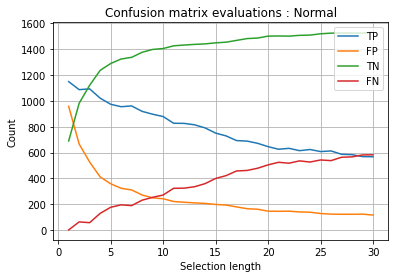

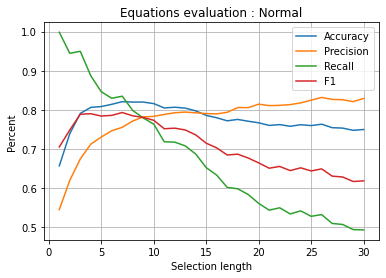

In [15]:
# Plot the up to length of 30 results
display(big_eval_df.plot.line(grid=True, title='Confusion matrix evaluations : Normal', xlabel="Selection length", ylabel="Count"))
display(small_eval_df.plot.line(grid=True, title='Equations evaluation : Normal', xlabel="Selection length", ylabel="Percent"))

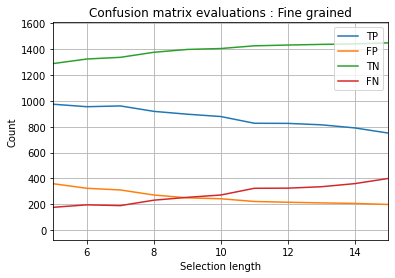

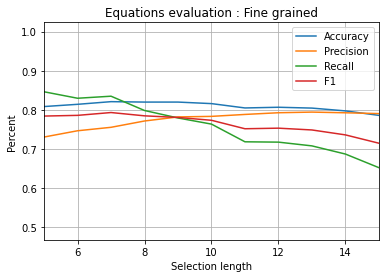

In [16]:
# Zoom into the overlap in the graph and show
display(big_eval_df.plot.line(grid=True, title='Confusion matrix evaluations : Fine grained',  xlabel="Selection length", ylabel="Count", xlim=(5,15)))
display(small_eval_df.plot.line(grid=True, title='Equations evaluation : Fine grained', xlabel="Selection length", ylabel="Percent", xlim=(5,15)))

In [17]:
# Show all the test length results
display(eval_df)

,TP,FP,TN,FN,Accuracy,Precision,Recall,F1
1,1149,958,690,2,0.657020,0.545325,0.998262,0.705341
2,1087,666,982,64,0.739193,0.620080,0.944396,0.748623
3,1093,527,1121,58,0.790997,0.674691,0.949609,0.788885
4,1021,412,1236,130,0.806359,0.712491,0.887055,0.790248
5,974,359,1289,177,0.808503,0.730683,0.846221,0.784219
6,955,324,1324,196,0.814219,0.746677,0.829713,0.786008
7,961,311,1337,190,0.821008,0.755503,0.834926,0.793232
8,919,272,1376,232,0.819936,0.771620,0.798436,0.784799
9,897,250,1398,254,0.819936,0.782040,0.779322,0.780679
10,879,243,1405,272,0.816006,0.783422,0.763684,0.773427


I decided the contents to be the top most occurring in one group which occur more than the other. I chose this because it will show the relevant words in the document which has a higher probability of occurring though choosing the most occurring words during initial training.

I chose the length via finding a sweet spot by creating line graphs and seeing where most overlap occurs, which was in between 1-10, when i replotted for that area I noticed it was 9 and in the next code block i have set it to this size. I chose this as once past this f1 and recall fall as well as accuracy and precision rising. If I wanted a particular attribute I could go left for more recall or right for more precision however 9 is the most balanced of these attributes of the classifier so we can classify book and dvd at roughly the same level.

F1 precision and recall all are roughly the same, higher end of 0.70s, however accuracy is in the 0.80s. Accuracy is the proportion of items in the test set that are classified correctly, I got 0.81 which is a good score. For recall, this means the proportion of book documents which are predicted correctly, is fairly high but could be better, specifically 0.77. Precision is the proportion of books predictions that are correct, I got 0.78. We want to aim for a high F1 as we want a high precision and recall, I got 0.780679 which is a good rate.




3) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [20%]

In [18]:
# Generate new training dara with optimum size
top_book_freq = tuplist_to_dict(top_k_freq(book_freq, dvd_freq, 9))
top_dvd_freq = tuplist_to_dict(top_k_freq(dvd_freq, book_freq, 9))

In [19]:
# Train both types of classifier
classifier = DVDOrBookClassifier(top_book_freq, top_dvd_freq, 9)
nbclassifier = nltk.NaiveBayesClassifier.train(training_data)

# Seperate thr docs and labels from eachother
docs,labels=zip(*testing_data)

# Details for each classifier to loop through
classifier.classify_many(docs)
con_matrixes = [(ConfusionMatrix(classifier.classify_many(docs),labels), 'My Classifier', classifier),
                (ConfusionMatrix(nbclassifier.classify_many(docs),labels), 'NTLK NB Classifier', nbclassifier)]

In [20]:
# Index for bar plot
index = ['My Classifier', 'NTLK NB Classifier']

# Lists to store results
big_test_data = []
small_test_data = []

# Get confusion matrix and arrcuracy results for both classifier
for con_matrix in con_matrixes:
  big_test_data.append( (con_matrix[0].TP, con_matrix[0].FP, con_matrix[0].TN, con_matrix[0].FN) )
  small_test_data.append( (classifier_accuracy(con_matrix[2], testing_data), con_matrix[0].precision(), con_matrix[0].recall(), con_matrix[0].f1()) )

# Create the dataframes for whole numbers and floats
big_test_data_df = pd.DataFrame(big_test_data, columns = ["TP", "FP", "TN", "FN"], index = index)
small_test_data_df = pd.DataFrame(small_test_data, columns = ["Accuracy", "Precision", "Recall", "F1"], index = index)

,TP,FP,TN,FN
My Classifier,897,250,1398,254
NTLK NB Classifier,1027,50,1598,124


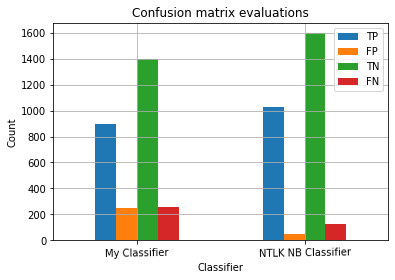

In [21]:
# Display whole numbers
display(big_test_data_df)
display(big_test_data_df.plot.bar(rot = 1, title = "Confusion matrix evaluations", xlabel="Classifier", ylabel="Count", grid = True))

,Accuracy,Precision,Recall,F1
My Classifier,0.819936,0.782040,0.779322,0.780679
NTLK NB Classifier,0.937835,0.953575,0.892268,0.921903


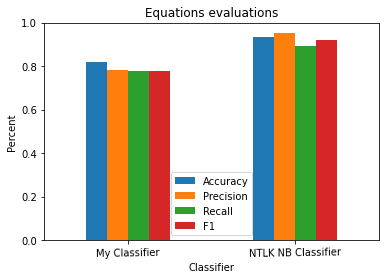

In [22]:
# Display float numbers
display(small_test_data_df)
display(small_test_data_df.plot.bar(rot = 1, title='Equations evaluations', xlabel="Classifier", ylabel="Percent"))

The NLTK naive bayes classifier outranks my classifier, as their results are stable within the 0.90s while my classifier is stable within the 0.70s. The NB is better because it calculates the probabilities assuming independance rather than just seeing if one of the top most occuring word appears in a review like my classifier does. My Classifier still does a good job however could do better through a method like naive bayes. They both do a better job at classifying DVDs over Books.

4) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [30%] 

In [23]:
def experiment(testing_data):
  """
  Used to find confusion matrix results for different lengths of training data 
  for either NB and the classifier I wrote to be used to plot the data over
  increasing length

  :param testing_data; The data to test the classifiers on
  :return: 
      myc_test_data_df: Formatted dataframe for my classifier
      nb_test_data_df: Formatted dataframe for nb classifier
  """

  # The different labels for the dataframes
  columns = ["Training Size", "Accuracy", "Precision", "Recall", "F1"]

  # The test results
  myc_test_results = []
  nb_test_results = []

  docs,labels=zip(*testing_data)

  # Get incriments of 100 of training data for classifiers to mesure confusion
  # matrix data for each 100 up to 4000 from 1
  for i in range(1, 4102, 100):

    # Train the classifiers
    myclassifier = DVDOrBookClassifier({}, {}, 10)
    myclassifier.train(training_data[:i])
    nbclassifier = nltk.NaiveBayesClassifier.train(training_data[:i])

    # Get classifier evaluations
    my_cm = ConfusionMatrix(myclassifier.classify_many(docs),labels)
    nb_cm = ConfusionMatrix(nbclassifier.classify_many(docs),labels)

    # Adds results to correct vars
    myc_test_results.append( (i, classifier_accuracy(myclassifier, testing_data), my_cm.precision(), my_cm.recall(), my_cm.f1()) )
    nb_test_results.append( (i, classifier_accuracy(nbclassifier, testing_data), nb_cm.precision(), nb_cm.recall(), nb_cm.f1()) )

    print(".", end = "")
    
  # Create the appropriate dataframes ffor the different scales of plot
  myc_test_data_df = pd.DataFrame(myc_test_results, columns = columns)
  nb_test_data_df = pd.DataFrame(nb_test_results, columns = columns)

  return myc_test_data_df, nb_test_data_df

In [24]:
# Get the two different scopes of results to see the progress of each value as the length of training data increases
myc_df, nb_df = experiment(testing_data)

..........................................

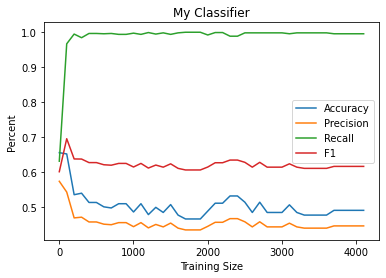

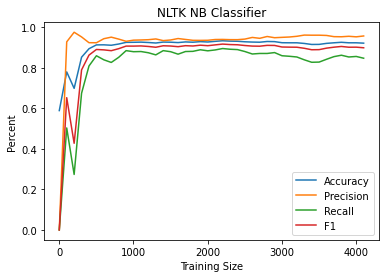

In [25]:
# Plot the results of experiment
myc_df.plot.line(x=0, title="My Classifier", ylabel="Percent")
nb_df.plot.line(x=0, title="NLTK NB Classifier", ylabel="Percent")

This experiment I investigate the performance trend of increasing the amount of training data per classifier and compare and contrast these results to show which is better overall.

I done this by training the classifiers in jumps of 100 to see a more fine grained view of the changes within the different ways to measure the effectiveness of the classifier. I put a limit to 4000 to see where the results are heading. I slowly introduce more of the set to see what will happen when more training data is added to each classifier.

My classifier will have the length of top frequencies at 25 throughout the experiment.

The results are rather distrabuted for my classifier, having a small recall at first but then a higher recall shortly after, thr F1 is stable throughout within the 60th percential, and accuracy bring low as well as precision, this classifier is not great. The F1 is low which is not what we are aiming for as we want good precision and recall. 

The naive bayes graph shows us that it is highly effective, all four groups being in the 80th percential consistantly after 1000 words have been trained on the classifier. This is because of how this classifier works, through naively assuming independence, the sharp increase at the beginning is because of this. F1 score is great and vastly better than my classifier

In conclusion, the naive bayes classifier outperforms my simple classifier due to naive bayes algorithm, my class has better recall over the naive bayes classifier however that is the only measure which is better than naive bayes.

In [26]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/NLE Notebooks/assessment/NLEassignment1.ipynb"
question_count=388

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

/usr/local/lib/python3.6/dist-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Submission length is 743
